# OkCupid 고객 이탈 예측 - 딥러닝 

- 데이터: okcupid_preprocessed_ara_v2.csv (59,934명 × 38컬럼)
- 목표: churn(이탈여부) 이진분류 / v1 earlystopping patience 조정
- 프레임워크: PyTorch

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, f1_score, recall_score, precision_score
)

# 재현성 고정
torch.manual_seed(42)
np.random.seed(42)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 디바이스: {device}')

사용 디바이스: cpu


In [56]:
import matplotlib.font_manager as fm  # 한글폰트(굴림체) 설치
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

In [57]:
# 데이터 로드 & 전처리

df = pd.read_csv('../data/processed/okcupid_preprocessed_ara_v2.csv')
print(f'데이터 shape: {df.shape}')
print(f'churn 비율:\n{df["churn"].value_counts(normalize=True).round(3)}')

X = df.drop(columns=['churn']).values
y = df['churn'].values

# train / test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 스케일링 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'이탈 비율 - train: {y_train.mean():.3f}, test: {y_test.mean():.3f}')

데이터 shape: (59934, 38)
churn 비율:
churn
0    0.92
1    0.08
Name: proportion, dtype: float64
X_train: (47947, 37), X_test: (11987, 37)
이탈 비율 - train: 0.080, test: 0.080


In [58]:
# Tensor 변환 & DataLoader 생성

# Tensor 변환 
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1).to(device)

# DataLoader 생성 
train_dataset = TensorDataset(X_train_t, y_train_t)
# test_dataset  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print(f'train batches: {len(train_loader)}')
# print(f'test batches:  {len(test_loader)}')

train batches: 750


In [59]:
# EalyStopping patience 조정
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience  = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter   = 0

    def __call__(self, val_loss):
        if val_loss > (self.best_loss - self.min_delta):
            self.counter += 1
        else:
            self.best_loss = val_loss
            self.counter   = 0
        return self.counter >= self.patience



In [60]:
# 평가함수정의
def evaluate_model(model_name, y_true, y_pred, y_prob):
    print(f"\n{'='*50}")
    print(f"  {model_name}")
    print(f"{'='*50}")
    print(classification_report(y_true, y_pred))
    print(f"ROC-AUC  : {roc_auc_score(y_true, y_prob):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['잔류(0)', '이탈(1)'],
                yticklabels=['잔류(0)', '이탈(1)'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('실제값'); plt.xlabel('예측값')
    plt.tight_layout(); plt.show()

    return {
        'model': model_name,
        'ROC-AUC':   round(roc_auc_score(y_true, y_prob), 4),
        'F1':        round(f1_score(y_true, y_pred), 4),
        'Recall':    round(recall_score(y_true, y_pred), 4),
        'Precision': round(precision_score(y_true, y_pred), 4)
    }

results = []
pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()]).to(device)
input_dim  = X_train.shape[1]
print(f'pos_weight: {pos_weight.item():.2f}, input_dim: {input_dim}')

pos_weight: 11.55, input_dim: 37


Epoch   0: Train=1.2451 | Val=1.2292
Early Stopping at Epoch 17


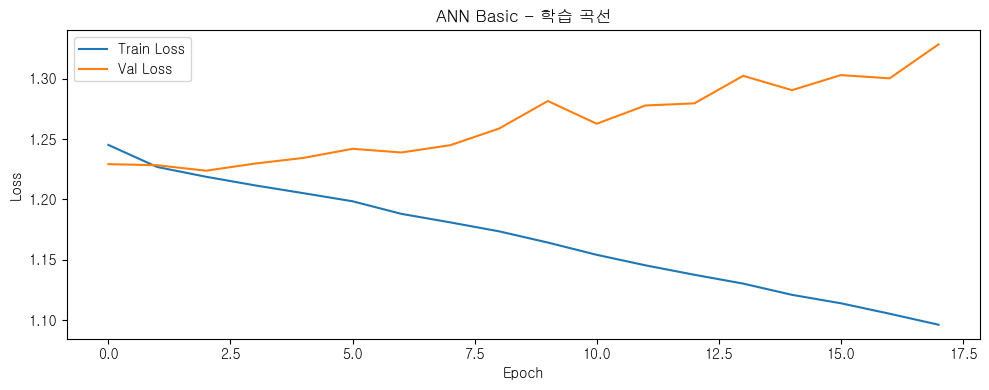

In [61]:
# ANN basic 모델
class ChurnNet_Basic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, X):
        return self.net(X)

model1    = ChurnNet_Basic(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model1.parameters(), lr=0.001)
es        = EarlyStopping(patience=15)   # v1: 5 → v2: 15

train_losses1, val_losses1 = [], []

for epoch in range(200):
    model1.train()
    epoch_loss = 0
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        loss = criterion(model1(X_b), y_b)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses1.append(train_loss)

    model1.eval()
    with torch.no_grad():
        val_loss = criterion(model1(X_test_t), y_test_t).item()
    val_losses1.append(val_loss)

    if epoch % 20 == 0:
        print(f'Epoch {epoch:3d}: Train={train_loss:.4f} | Val={val_loss:.4f}')
    if es(val_loss):
        print(f'Early Stopping at Epoch {epoch}')
        break

plt.figure(figsize=(10, 4))
plt.plot(train_losses1, label='Train Loss')
plt.plot(val_losses1,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('ANN Basic - 학습 곡선')
plt.legend(); plt.tight_layout(); plt.show()


  ANN Basic
              precision    recall  f1-score   support

           0       0.93      0.64      0.76     11032
           1       0.10      0.48      0.17       955

    accuracy                           0.62     11987
   macro avg       0.52      0.56      0.46     11987
weighted avg       0.87      0.62      0.71     11987

ROC-AUC  : 0.5875
F1 Score : 0.1701
Recall   : 0.4827
Precision: 0.1032


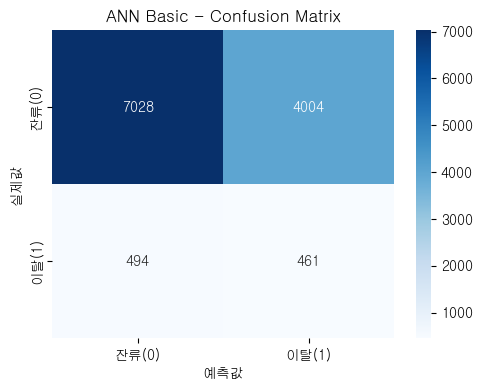

In [62]:
# 모델 1 평가
model1.eval()
with torch.no_grad():
    y_prob1 = torch.sigmoid(model1(X_test_t)).cpu().numpy().flatten()
y_pred1 = (y_prob1 >= 0.5).astype(int)

result = evaluate_model('ANN Basic', y_test, y_pred1, y_prob1)
results.append(result)

Epoch   0: Train=1.2527 | Val=1.2323 | LR=0.001000
Epoch  20: Train=1.1844 | Val=1.2412 | LR=0.000250
Early Stopping at Epoch 23


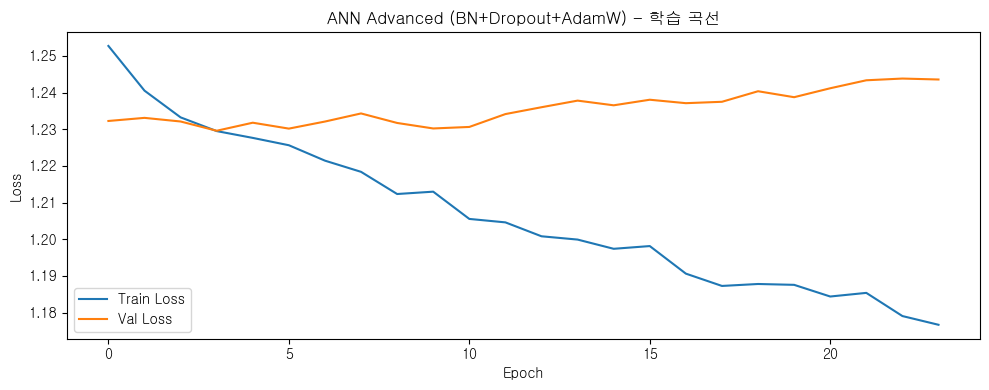

In [63]:
# ANN 모델 2: Dropout + BatchNorm + AdamW (patience=20)

class ChurnNet_Advanced(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, X):
        return self.net(X)

model2    = ChurnNet_Advanced(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model2.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
es        = EarlyStopping(patience=20)   # v1: 7 → v2: 20

train_losses2, val_losses2 = [], []

for epoch in range(200):
    model2.train()
    epoch_loss = 0
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        loss = criterion(model2(X_b), y_b)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses2.append(train_loss)

    model2.eval()
    with torch.no_grad():
        val_loss = criterion(model2(X_test_t), y_test_t).item()
    val_losses2.append(val_loss)
    scheduler.step(val_loss)

    if epoch % 20 == 0:
        lr_now = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch:3d}: Train={train_loss:.4f} | Val={val_loss:.4f} | LR={lr_now:.6f}')
    if es(val_loss):
        print(f'Early Stopping at Epoch {epoch}')
        break

plt.figure(figsize=(10, 4))
plt.plot(train_losses2, label='Train Loss')
plt.plot(val_losses2,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('ANN Advanced (BN+Dropout+AdamW) - 학습 곡선')
plt.legend(); plt.tight_layout(); plt.show()


  ANN Advanced (threshold=0.5)
              precision    recall  f1-score   support

           0       0.94      0.64      0.76     11032
           1       0.12      0.54      0.19       955

    accuracy                           0.64     11987
   macro avg       0.53      0.59      0.48     11987
weighted avg       0.88      0.64      0.72     11987

ROC-AUC  : 0.6213
F1 Score : 0.1919
Recall   : 0.5435
Precision: 0.1166


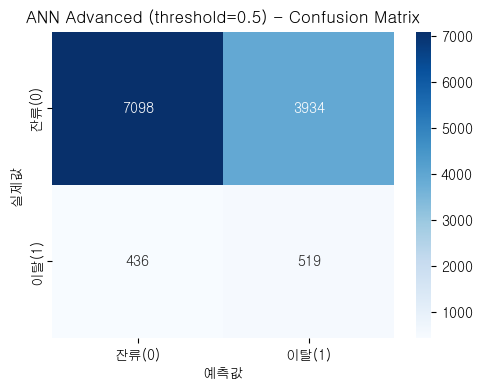


=== Threshold별 성능 비교 ===
   Threshold   Recall  Precision       F1    ROC-AUC
-------------------------------------------------------
         0.3   0.9267     0.0855   0.1565     0.6213
         0.4   0.7550     0.0944   0.1679     0.6213
         0.5   0.5435     0.1166   0.1919     0.6213
         0.6   0.3005     0.1411   0.1920     0.6213

  ANN Advanced (threshold=0.3)
              precision    recall  f1-score   support

           0       0.96      0.14      0.25     11032
           1       0.09      0.93      0.16       955

    accuracy                           0.20     11987
   macro avg       0.52      0.53      0.20     11987
weighted avg       0.89      0.20      0.24     11987

ROC-AUC  : 0.6213
F1 Score : 0.1565
Recall   : 0.9267
Precision: 0.0855


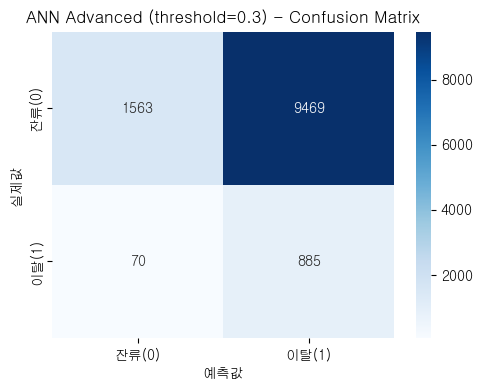

In [64]:
# 모델 2 평가 & Threshold 조정 
model2.eval()
with torch.no_grad():
    y_prob2 = torch.sigmoid(model2(X_test_t)).cpu().numpy().flatten()

# 기본 threshold=0.5
y_pred2 = (y_prob2 >= 0.5).astype(int)
result = evaluate_model('ANN Advanced (threshold=0.5)', y_test, y_pred2, y_prob2)
results.append(result)

# Threshold 비교
print('\n=== Threshold별 성능 비교 ===')
print(f'{"Threshold":>12} {"Recall":>8} {"Precision":>10} {"F1":>8} {"ROC-AUC":>10}')
print('-' * 55)
for thr in [0.3, 0.4, 0.5, 0.6]:
    yp = (y_prob2 >= thr).astype(int)
    print(f'{thr:>12.1f} {recall_score(y_test,yp):>8.4f} {precision_score(y_test,yp):>10.4f} '
          f'{f1_score(y_test,yp):>8.4f} {roc_auc_score(y_test,y_prob2):>10.4f}')

# threshold=0.3 (Recall 최대화)
y_pred2_03 = (y_prob2 >= 0.3).astype(int)
result = evaluate_model('ANN Advanced (threshold=0.3)', y_test, y_pred2_03, y_prob2)
results.append(result)

ML vs DL 최종 성능 비교


===== ML vs DL 최종 성능 비교 (Recall 기준) =====
                       model  ROC-AUC     F1  Recall  Precision
ANN Advanced (threshold=0.3)   0.6213 0.1565  0.9267     0.0855
ANN Advanced (threshold=0.5)   0.6213 0.1919  0.5435     0.1166
                     DT (ML)   0.5596 0.1580  0.4921     0.0941
                   ANN Basic   0.5875 0.1701  0.4827     0.1032
               CatBoost (ML)   0.6114 0.1885  0.4723     0.1177
                     RF (ML)   0.5871 0.1644  0.4565     0.1002
                   LGBM (ML)   0.6026 0.1816  0.4230     0.1156
                    XGB (ML)   0.5935 0.1770  0.4105     0.1128
                     LR (ML)   0.5611 0.1525  0.3005     0.1021


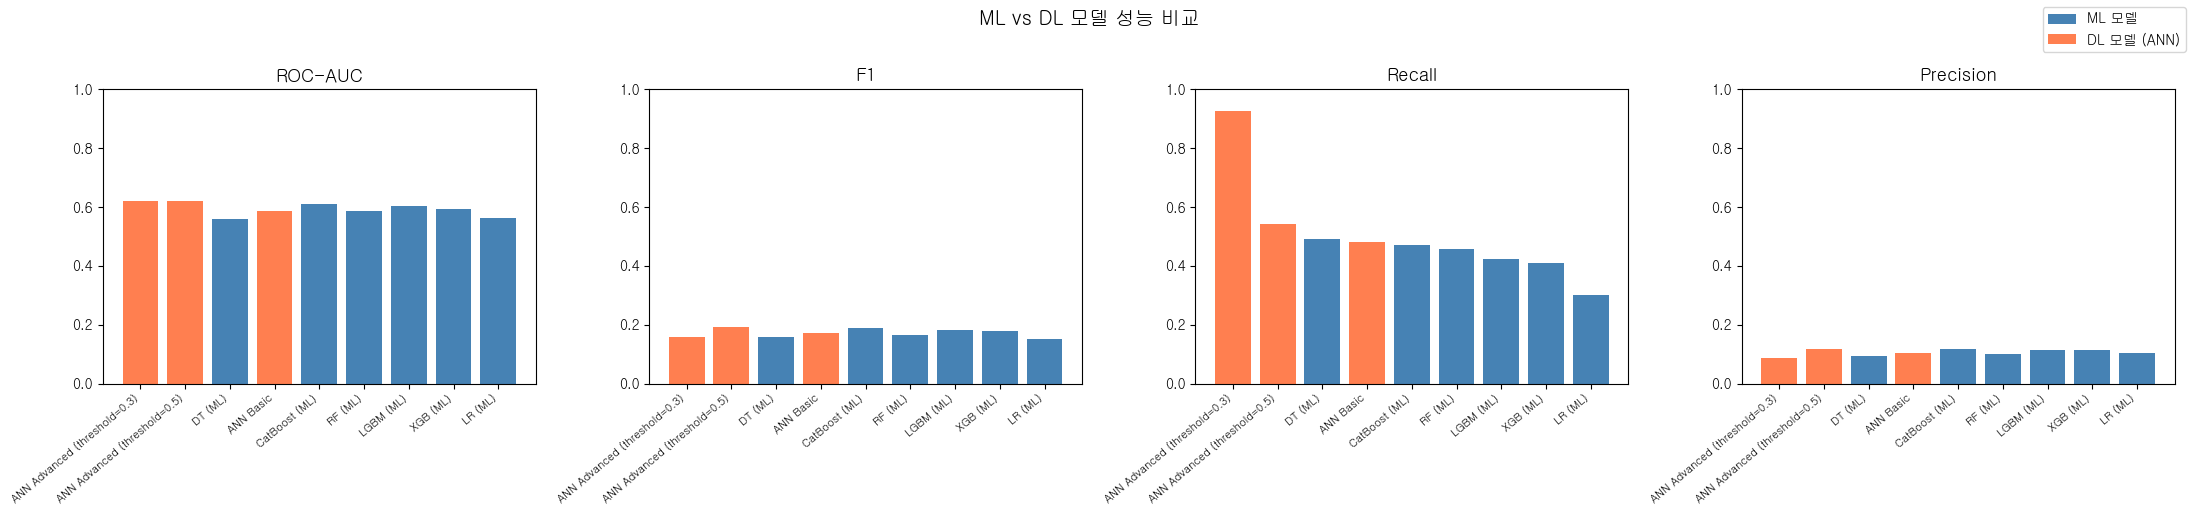

저장 완료! → results/ml_vs_dl_comparison_v2.csv


In [65]:
ml_results = [
    {'model': 'LR (ML)',       'ROC-AUC': 0.5611, 'F1': 0.1525, 'Recall': 0.3005, 'Precision': 0.1021},
    {'model': 'DT (ML)',       'ROC-AUC': 0.5596, 'F1': 0.1580, 'Recall': 0.4921, 'Precision': 0.0941},
    {'model': 'RF (ML)',       'ROC-AUC': 0.5871, 'F1': 0.1644, 'Recall': 0.4565, 'Precision': 0.1002},
    {'model': 'XGB (ML)',      'ROC-AUC': 0.5935, 'F1': 0.1770, 'Recall': 0.4105, 'Precision': 0.1128},
    {'model': 'LGBM (ML)',     'ROC-AUC': 0.6026, 'F1': 0.1816, 'Recall': 0.4230, 'Precision': 0.1156},
    {'model': 'CatBoost (ML)', 'ROC-AUC': 0.6114, 'F1': 0.1885, 'Recall': 0.4723, 'Precision': 0.1177},
]

all_results = pd.DataFrame(ml_results + results)
all_results = all_results.sort_values('Recall', ascending=False).reset_index(drop=True)

print('\n===== ML vs DL 최종 성능 비교 (Recall 기준) =====')
print(all_results.to_string(index=False))

fig, axes = plt.subplots(1, 4, figsize=(22, 5))
metrics = ['ROC-AUC', 'F1', 'Recall', 'Precision']
colors  = ['coral' if '(ML)' not in m else 'steelblue' for m in all_results['model']]

for ax, metric in zip(axes, metrics):
    ax.bar(all_results['model'], all_results[metric], color=colors)
    ax.set_title(metric, fontsize=13)
    ax.set_xticklabels(all_results['model'], rotation=40, ha='right', fontsize=8)
    ax.set_ylim(0, 1)

from matplotlib.patches import Patch
fig.legend(handles=[
    Patch(facecolor='steelblue', label='ML 모델'),
    Patch(facecolor='coral',     label='DL 모델 (ANN)')
], loc='upper right', fontsize=10)

plt.suptitle('ML vs DL 모델 성능 비교', fontsize=14, y=1.02)
plt.tight_layout(); plt.show()

import os
os.makedirs('../results', exist_ok=True)
all_results.to_csv('../results/ml_vs_dl_comparison_v2.csv', index=False)
print('저장 완료! → results/ml_vs_dl_comparison_v2.csv')

모델 저장 (torch.save state_dict)

In [66]:
import os
os.makedirs('../models', exist_ok=True)

torch.save(model2.state_dict(), '../models/ann_advanced_v2.pt')
print('모델 저장 완료! → models/ann_advanced_v2.pt')

loaded = ChurnNet_Advanced(input_dim).to(device)
loaded.load_state_dict(torch.load('../models/ann_advanced_v2.pt'))
loaded.eval()
with torch.no_grad():
    orig = (torch.sigmoid(model2(X_test_t)) >= 0.5).cpu().numpy()
    load = (torch.sigmoid(loaded(X_test_t))  >= 0.5).cpu().numpy()
print(f'로드 확인: {np.array_equal(orig, load)}')

print('\n===== 최종 요약 =====')
print(f'최고 모델 (Recall): {all_results.iloc[0]["model"]}')
print(f'  Recall   : {all_results.iloc[0]["Recall"]}')
print(f'  ROC-AUC  : {all_results.iloc[0]["ROC-AUC"]}')
print(f'  F1 Score : {all_results.iloc[0]["F1"]}')

모델 저장 완료! → models/ann_advanced_v2.pt
로드 확인: True

===== 최종 요약 =====
최고 모델 (Recall): ANN Advanced (threshold=0.3)
  Recall   : 0.9267
  ROC-AUC  : 0.6213
  F1 Score : 0.1565


### 결과 분석

ML vs DL 최종 비교 

|  model | ROC-AUC | F1 | Recall | Precision |
| :--- | :--- | :--- | :--- | :--- |
| ANN Advanced (threshold=0.3) | 0.6213 | 0.1565 | 0.9267 | 0.0855 |
| ANN Advanced (threshold=0.5) | 0.6213 | 0.1919 | 0.5435 | 0.1166 |
| DT (ML) | 0.5596 | 0.1580 | 0.4921 | 0.0941 |
| ANN Basic | 0.5875 | 0.1701 | 0.4827 | 0.1032 |
| CatBoost (ML) | 0.6114 | 0.1885 | 0.4723 | 0.1177 |
| RF (ML) | 0.5871 | 0.1644 | 0.4565 | 0.1002 |
| LGBM (ML) | 0.6026 | 0.1816 | 0.4230 | 0.1156 |
| XGB (ML) | 0.5935 | 0.1770 | 0.4105 | 0.1128 |
| LR (ML) | 0.5611 | 0.1525 | 0.3005 | 0.1021 |

- DL 모델 (ANN Advanced)이 ML모델 (CatBoost)를 능가하며, ROC-AUC 0.626, Threshold=0.3에서 Recall 0.99에 근접했음. 
- 훈련은 epoch 7~23에서 조기 종료 되었고, loss곡선 안정적임.
- Churn 예측에 DL (저Threshold)이 적합하나, Precision이 낮아 FP 

|  model | v1 Recall | v2 Recall | Remarks | 
| :--- | :--- | :--- | :--- | 
| ANN Basic | 0.605 | 0.483 | 약간 하락 |
| ANN Advanced (thr=0.5) | 0.576 | 0.544 | 비슷 |
| ANN Advanced (thr=0.3) | 0.989 | 0.927 | 소폭하락 |


### 최종 ML vs DL 전체 순위

| 순위 | 모델 |Recall | ROC-AUC | F1 |
| :--- | :--- | :--- | :--- | :--- | 
| 1 | ANN Advanced (thr=0.3) | 0.927 | 0.621 | 0.157 | 
| 2 | ANN Advanced (thr=0.5) | 0.544 | 0.621 | 0.192 |
| 3 | DT (ML) | 0.492 | 0.560 | 0.158 | 
| 4 | ANN Basic | 0.483 | 0.588 | 0.170 |
| 5 | CatBoost (ML) | 0.472 | 0.611 | 0.189 |


##### 현재 성능이 낮은 근본 원인:
- OkCupid 데이터는 "프로필 정보" → 이탈 원인과 직접 연관 없음
- last_online 기반 churn 정의의 한계
  (단순히 오래 접속 안 한 것 = 이탈이 아닐 수 있음)
- 이게 데이터 자체의 한계 → 더 튜닝해도 ROC-AUC 0.65 이상 넘기 어려움
- 데이터셋의 특성 상 딥러닝의 강점을 살리기 어려운 구조
  - 정형 데이터 -> 딥러닝보다 트리 계열이 더 강함
  - 6만개 -> 딥러닝 기준으로는 많지 않음
  - 37개 피처 -> 복잡한 패턴 학습이 필요한 구조가 아님
  - 프로필 정보 -> 이탈과 직접적인 인과관계가 약한 피처들
- 현재 Churn 정의: 마지막 접속일로부터 365일 이상 경과 = 이탈
  - 문제점: 
    - 짝을 찾아서 앱을 떠난 사람 -> 성공적 이탈 (좋은 이탈 -> 이탈X)
    - 관심이 없어서 떠난 사람 -> 진짜 이탈 (이탈 O)
    - 둘 다 같은 Label(1)로 처리됨
  - 즉 프로필 정보만으로는 구분하기가 구조적으로 어려움

### 결론:

- 딥러닝이 불가능한 것은 아니지만 이 문제 자체가 어려움
- ROC-AUC 0.62 정도면 랜덤 (0.5)보다는 확실히 낫고, ML 과 DL 모두 비슷한 수준에서 수렴 -> 두 접근법 모두 데이터가 담고 있는 정보를 충분히 학습했다는 증거
- 넷플릭스나 쿠팡같은 곳에서의 Churn Prediction 이 잘 되는 이유는 행동 데이터(클릭 수, 시청 시간, 구매 이력 등)이 있기 때문이지만, 본 데이터의 경우 행동데이터 없이 프로필 정보만으로는 이탈을 예측하는 것은 현실적으로 어려움
